In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
# Load satellite metadata and parse timestamp
df_satellite = pd.read_csv('satellite_images.csv', parse_dates=['timestamp'])

# Load hydro dataset and parse date
df_hydro = pd.read_csv(
    'hydro_dataset.11_04.csv',
    parse_dates=['date'],
    dayfirst=False  # Adjust if dates are in DD/MM/YYYY format
)

In [3]:
# Check date ranges
print("Satellite date range:", df_satellite['timestamp'].min(), "to", df_satellite['timestamp'].max())
print("Hydro date range:", df_hydro['date'].min(), "to", df_hydro['date'].max())

Satellite date range: 2017-04-24 00:00:00 to 2025-03-18 00:00:00
Hydro date range: 2015-06-26 00:00:00 to 2025-03-31 00:00:00


In [4]:
# Merge datasets using left join on timestamp and date, then drop the redundant 'date' column
merged_df = pd.merge(
    df_satellite,
    df_hydro,
    left_on='timestamp',
    right_on='date',
    how='left'
).drop(columns=['date']).sort_values('timestamp').reset_index(drop=True)

In [ ]:
# Calculate 'extreme_precipitation' column
merged_df['extreme_prec'] = 0

for i in range(len(merged_df)):
    current_ts = merged_df.at[i, 'timestamp']
    start_ts = merged_df.at[i-1, 'timestamp'] if i > 0 else pd.Timestamp.min
    
    # Filter hydro data between start_ts and current_ts
    mask = (
        (df_hydro['date'] > start_ts) & 
        (df_hydro['date'] <= current_ts) & 
        (df_hydro['precipitation_mm'] >= 50)
    )
    merged_df.at[i, 'extreme_prec'] = df_hydro.loc[mask, 'precipitation_mm'].count()

# Check results
print(merged_df[['timestamp', 'extreme_prec']])


     timestamp  extreme_prec
0   2017-04-24             0
1   2017-05-17             0
2   2017-05-27             0
3   2017-06-13             0
4   2017-06-26             0
..         ...           ...
242 2024-11-11             0
243 2024-11-16             0
244 2024-11-18             0
245 2025-03-18             0
246 2025-03-18             0

[247 rows x 2 columns]


In [13]:
# Calculate 'extreme_discharge' column
merged_df['extreme_discharge'] = 0

for i in range(len(merged_df)):
    current_ts = merged_df.at[i, 'timestamp']
    start_ts = merged_df.at[i-1, 'timestamp'] if i > 0 else pd.Timestamp.min
    
    # Filter hydro data between start_ts and current_ts
    mask = (
        (df_hydro['date'] > start_ts) & 
        (df_hydro['date'] <= current_ts) & 
        (df_hydro['discharge'] >= 12)
    )
    merged_df.at[i, 'extreme_discharge'] = df_hydro.loc[mask, 'discharge'].count()

# Check results
print(merged_df[['timestamp', 'extreme_discharge']])

     timestamp  extreme_discharge
0   2017-04-24                 30
1   2017-05-17                  0
2   2017-05-27                  0
3   2017-06-13                  0
4   2017-06-26                  0
..         ...                ...
242 2024-11-11                  0
243 2024-11-16                  0
244 2024-11-18                  0
245 2025-03-18                  0
246 2025-03-18                  0

[247 rows x 2 columns]


In [8]:
merged_df

,system:index,image_id,timestamp,.geo,discharge,water_level,soil_moisture_om,precipitation_mm,precipitation_cum,discharge_cum,delta_discharge,delta_precipitation,precipitation_extreme,extreme
0,20170424T101031_20170424T101120_T32TPT,0,2017-04-24,"{""type"":""MultiPoint"",""coordinates"":[]}",3.91,23.0,0.374958,0.0,2211.40,3747.49,3.91,0.0,0,0
1,20170517T102031_20170517T102352_T32TPT,1,2017-05-17,"{""type"":""MultiPoint"",""coordinates"":[]}",5.49,30.0,0.385208,0.0,2347.50,3870.37,5.49,0.0,0,0
2,20170527T102031_20170527T102301_T32TPT,2,2017-05-27,"{""type"":""MultiPoint"",""coordinates"":[]}",5.01,28.0,0.374167,0.0,2369.70,3924.22,5.01,0.0,0,0
3,20170613T101031_20170613T101608_T32TPT,3,2017-06-13,"{""type"":""MultiPoint"",""coordinates"":[]}",4.56,26.0,0.348667,0.0,2456.20,4015.89,4.56,0.0,0,0
4,20170626T102021_20170626T102321_T32TPT,4,2017-06-26,"{""type"":""MultiPoint"",""coordinates"":[]}",4.52,26.0,0.322125,3.0,2514.10,4080.24,4.52,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,20241111T102149_20241111T102150_T32TPT,242,2024-11-11,"{""type"":""MultiPoint"",""coordinates"":[]}",3.91,24.0,0.322542,0.0,12344.00,19362.99,3.91,0.0,0,0
243,20241116T102311_20241116T102651_T32TPT,243,2024-11-16,"{""type"":""MultiPoint"",""coordinates"":[]}",3.78,23.0,0.342458,0.0,12345.62,19382.40,3.78,0.0,0,0
244,20241118T101219_20241118T101221_T32TPT,244,2024-11-18,"{""type"":""MultiPoint"",""coordinates"":[]}",3.69,23.0,0.341000,0.1,12346.52,19389.80,3.69,0.1,0,0
245,20250318T100639_20250318T101649_T32TPT,245,2025-03-18,"{""type"":""MultiPoint"",""coordinates"":[]}",3.11,20.0,0.359500,0.0,12511.04,19789.96,3.11,0.0,0,0


In [14]:
merged_df = merged_df.drop(columns=['precipitation_extreme'])

In [15]:
merged_df = merged_df.rename(columns={'extreme_prec': 'extreme_precipitation', })

In [ ]:
merged_df.head()

In [16]:
# Saving the final dataframe to a CSV file
merged_df.to_csv('final_data.csv', index=False)
print("New dataset 'final_data.csv' created successfully!")

New dataset 'final_data.csv' created successfully!


### Done!

In [17]:
merged_df.head()

,system:index,image_id,timestamp,.geo,discharge,water_level,soil_moisture_om,precipitation_mm,precipitation_cum,discharge_cum,delta_discharge,delta_precipitation,extreme_precipitation,extreme_discharge
0,20170424T101031_20170424T101120_T32TPT,0,2017-04-24,"{""type"":""MultiPoint"",""coordinates"":[]}",3.91,23.0,0.374958,0.0,2211.4,3747.49,3.91,0.0,0,30
1,20170517T102031_20170517T102352_T32TPT,1,2017-05-17,"{""type"":""MultiPoint"",""coordinates"":[]}",5.49,30.0,0.385208,0.0,2347.5,3870.37,5.49,0.0,0,0
2,20170527T102031_20170527T102301_T32TPT,2,2017-05-27,"{""type"":""MultiPoint"",""coordinates"":[]}",5.01,28.0,0.374167,0.0,2369.7,3924.22,5.01,0.0,0,0
3,20170613T101031_20170613T101608_T32TPT,3,2017-06-13,"{""type"":""MultiPoint"",""coordinates"":[]}",4.56,26.0,0.348667,0.0,2456.2,4015.89,4.56,0.0,0,0
4,20170626T102021_20170626T102321_T32TPT,4,2017-06-26,"{""type"":""MultiPoint"",""coordinates"":[]}",4.52,26.0,0.322125,3.0,2514.1,4080.24,4.52,3.0,0,0


In [28]:
# Information about the resulting dataset 
print(f"Original satellite data shape: {df_satellite.shape}")
print(f"Original hydrologic data shape: {df_hydro.shape}")
print(f"Finalized dataset shape: {merged_df.shape}")
print(f"Number of extreme precipitation events: > 50 mm | {merged_df['extreme_precipitation'].sum()}")
print(f"Number of extreme discharge events:  > 12 m3/s | 109")

Original satellite data shape: (247, 4)
Original hydrologic data shape: (3567, 10)
Finalized dataset shape: (247, 14)
Number of extreme precipitation events: > 50 mm | 8
Number of extreme discharge events:  > 12 m3/s | 109


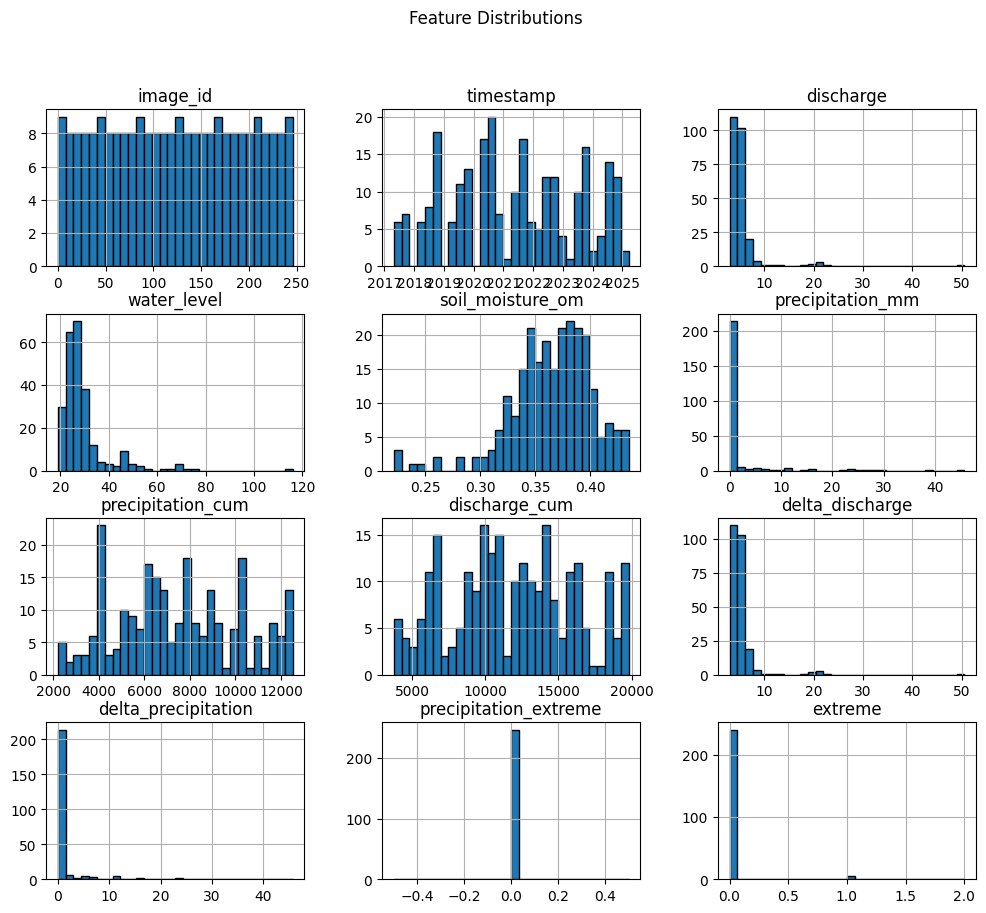

In [20]:
# Histograms of features
merged_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions')
plt.show()

In [18]:
# Summary Statistics
print("Summary Statistics:")
print(merged_df.describe())



Summary Statistics:
        image_id                      timestamp   discharge  water_level  \
count  247.00000                            247  247.000000   247.000000   
mean   123.00000  2021-05-04 18:21:51.740890624    5.462024    29.599190   
min      0.00000            2017-04-24 00:00:00    2.950000    19.000000   
25%     61.50000            2019-09-07 12:00:00    4.090000    24.000000   
50%    123.00000            2021-05-31 00:00:00    4.630000    27.000000   
75%    184.50000            2023-01-18 12:00:00    5.290000    30.000000   
max    246.00000            2025-03-18 00:00:00   50.500000   116.000000   
std     71.44695                            NaN    4.091498    10.958406   

       soil_moisture_om  precipitation_mm  precipitation_cum  discharge_cum  \
count        247.000000        247.000000         247.000000     247.000000   
mean           0.365077          1.803036        7448.918502   11874.431822   
min            0.221417          0.000000        2211.4000